In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from glob import glob
import time
from IPython import display
# from tqdm import tqdm_notebook as tqdm
from enum import Enum

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

tf.__version__

'1.15.0'

In [2]:
tf.test.is_gpu_available()

True

# Load and prepare the dataset

In [3]:
DATA_DIR = os.path.join('data', 'celebA')
IMG_PATH_PATTERN = os.path.join(DATA_DIR, '*.*')
CKPT_DIR = 'model'

N_SAMPLES = len(glob(IMG_PATH_PATTERN))
BUFFER_SIZE = 5000
BATCH_SIZE = 50

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
def decode_img(img_path):
    img_raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [128, 128]) # resize image
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5 # Normalize the images to [-1, 1]
    return img

In [ ]:
dataset = tf.data.Dataset.list_files(IMG_PATH_PATTERN)
dataset = dataset.map(decode_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat().prefetch(tf.data.experimental.AUTOTUNE)

iterator = dataset.make_one_shot_iterator()
image_ph = iterator.get_next()

# Model

In [6]:
WEIGHT_INIT = tf.contrib.layers.xavier_initializer()
BIAS_INIT = tf.zeros_initializer()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
class TrainArg(Enum):
    FALSE = 0
    TRUE_UPDATE_U = 1
    TRUE_NO_UPDATE_U = 2

In [0]:
def _l2normalize(v, eps=1e-12):
    """l2 normize the input vector."""
    return v / (tf.reduce_sum(v ** 2) ** 0.5 + eps)


def spectral_norm(weights, u, num_iters=1, update_collection=None, with_sigma=False):
    w_shape = weights.shape.as_list()
    w_mat = tf.reshape(weights, [-1, w_shape[-1]])  # [-1, output_channel]
    u_ = u
    for _ in range(num_iters):
        v_ = _l2normalize(tf.matmul(u_, w_mat, transpose_b=True))
        u_ = _l2normalize(tf.matmul(v_, w_mat))

    sigma = tf.squeeze(tf.matmul(tf.matmul(v_, w_mat), u_, transpose_b=True))
    w_mat /= sigma
    if update_collection is None:
        with tf.control_dependencies([u.assign(u_)]):
            w_bar = tf.reshape(w_mat, w_shape)
    else:
        w_bar = tf.reshape(w_mat, w_shape)
        if update_collection != 'NO_OPS':
            tf.add_to_collection(update_collection, u.assign(u_))
    if with_sigma:
        return w_bar, sigma
    else:
        return w_bar

In [0]:
class SNConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, strides, padding, use_bias=True,
                 kernel_initializer=WEIGHT_INIT, bias_initializer=BIAS_INIT, **kwargs):
        super(SNConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        
    
    def build(self, input_shape):
        '''
        input_shape = (batch_size, height, width, channels_in)
        '''
        self.channels_in = input_shape.as_list()[-1]
        self.kernel = self.add_weight("kernel",
                                      shape=(self.kernel_size[0], self.kernel_size[1], self.channels_in, self.filters), 
                                      initializer=self.kernel_initializer)
        if self.use_bias:
            self.bias = self.add_weight("bias", shape=(self.filters,), initializer=self.bias_initializer)
        self.u = self.add_weight("u", shape=(1, self.kernel.shape.as_list()[-1]), initializer=tf.truncated_normal_initializer(), trainable=False)
        super(SNConv2D, self).build(input_shape)  # Be sure to call this at the end
    
    
    def call(self, inputs, training=None):
        if training == TrainArg.TRUE_UPDATE_U:
            x = tf.nn.conv2d(inputs, spectral_norm(self.kernel, self.u, update_collection=None), self.strides, self.padding)
        else:
            x = tf.nn.conv2d(inputs, spectral_norm(self.kernel, self.u, update_collection='NO_OPS'), self.strides, self.padding)
        if self.use_bias:
            x = tf.nn.bias_add(x, self.bias)
        return x

In [0]:
class SNDense(layers.Layer):
    def __init__(self, units, use_bias=True,
                 kernel_initializer=WEIGHT_INIT, bias_initializer=BIAS_INIT, **kwargs):
        super(SNDense, self).__init__(**kwargs)
        self.units = units
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        
    
    def build(self, input_shape):
        '''
        input_shape = (batch_size, ..., input_dim)
        '''
        self.input_dim = input_shape.as_list()[-1]
        self.kernel = self.add_weight("kernel", 
                                      shape=(self.input_dim, self.units), 
                                      initializer=self.kernel_initializer)
        if self.use_bias:
            self.bias = self.add_weight("bias", shape=(self.units,), initializer=self.bias_initializer)
        self.u = self.add_weight("u", shape=(1, self.kernel.shape.as_list()[-1]), initializer=tf.truncated_normal_initializer(), trainable=False)
        super(SNDense, self).build(input_shape)  # Be sure to call this at the end
    
    
    def call(self, inputs, training=None):
        if training == TrainArg.TRUE_UPDATE_U:
            x = tf.matmul(inputs, spectral_norm(self.kernel, self.u, update_collection=None))
        else:
            x = tf.matmul(inputs, spectral_norm(self.kernel, self.u, update_collection='NO_OPS'))
        if self.use_bias:
            x = tf.nn.bias_add(x, self.bias)
        return x

## 1. Self-Attention

In [0]:
class SelfAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        '''
        input_shape = (batch_size, height, width, channels)
        '''
        _, self.height, self.width, self.channels_in = input_shape.as_list()
        self.conv_f = SNConv2D(self.channels_in // 8, (1, 1), strides=(1, 1), padding='valid', name='conv_f')
        self.conv_g = SNConv2D(self.channels_in // 8, (1, 1), strides=(1, 1), padding='valid', name='conv_g')
        self.conv_h = SNConv2D(self.channels_in // 2, (1, 1), strides=(1, 1), padding='valid', name='conv_h')
        self.conv_v = SNConv2D(self.channels_in, (1, 1), strides=(1, 1), padding='valid', name='conv_v')
        self.gamma = self.add_weight('gamma', shape=(1,), initializer=tf.constant_initializer(0.0))
        super(SelfAttention, self).build(input_shape)  # Be sure to call this at the end
    
    
    def call(self, inputs, training=None):
        '''
        inputs - shape = (batch_size, height, width, channels)
        '''
        f = self.conv_f(inputs, training=training) # (batch_size, height, width, channels/8)
        f = layers.MaxPool2D(padding='SAME')(f) # (batch_size, height/2, width/2, channels/8)
        f = layers.Reshape((self.height * self.width // 4, self.channels_in // 8))(f) # (batch_size, height*width/4, channels/8)
        
        g = self.conv_g(inputs, training=training) # (batch_size, height, width, channels/8)
        g = layers.Reshape((self.height * self.width, self.channels_in // 8))(g) # (batch_size, height*width, channels/8)
        
        h = self.conv_h(inputs, training=training) # (batch_size, height, width, channels/2)
        h = layers.MaxPool2D(padding='SAME')(h) # (batch_size, height/2, width/2, channels/2)
        h = layers.Reshape((self.height * self.width // 4, self.channels_in // 2))(h) # (batch_size, height*width/4, channels/2)
        
        s = tf.matmul(g, f, transpose_b=True) # (batch_size, height*width, height*width/4)
        beta = tf.nn.softmax(s, axis=-1) # (batch_size, height*width, height*width/4)
        
        o = tf.matmul(beta, h) # (batch_size, height*width, channels/2)
        o = layers.Reshape((self.height, self.width, self.channels_in // 2))(o) # (batch_size, height, width, channels/2)
        o = self.conv_v(o, training=training) # (batch_size, height, width, channels)
        
        return self.gamma * o + inputs # (batch_size, height, width, channels)

## 2.Generator

In [0]:
class BatchNorm(layers.Layer):
    def __init__(self, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.bn = layers.BatchNormalization(momentum=0.9, epsilon=1e-05, name='batch_normalization')
        super(BatchNorm, self).build(input_shape)
        
    def call(self, inputs, training=None):
        x = self.bn(inputs, training=bool(training))
        return x


class UpResBlock(layers.Layer):
    def __init__(self, channels_out, **kwargs):
        super(UpResBlock, self).__init__(**kwargs)
        self.channels_out = channels_out
    
    def build(self, input_shape):
        '''
        input_shape = (batch_size, height, width, channels)
        '''
        self.deconv1 = SNConv2D(self.channels_out, (3, 3), strides=(1, 1), padding='same', use_bias=False, name='deconv1')
        self.deconv2 = SNConv2D(self.channels_out, (3, 3), strides=(1, 1), padding='same', name='deconv2')
        self.deconv3 = SNConv2D(self.channels_out, (1, 1), strides=(1, 1), padding='valid', use_bias=False, name='deconv3')
        self.bn1 = BatchNorm(name='bn1')
        self.bn2 = BatchNorm(name='bn2')
        super(UpResBlock, self).build(input_shape)  # Be sure to call this at the end
                
    def call(self, inputs, training=None):
        '''
        inputs - shape = (batch_size, height, width, channels)
        '''
        x = self.bn1(inputs, training=training)
        x = layers.ReLU()(x)
        x = layers.UpSampling2D()(x) # (batch_size, 2*height, 2*width, channels)
        x = self.deconv1(x, training=training) # (batch_size, 2*height, 2*width, channels_out)

        x = self.bn2(x, training=training)
        x = layers.ReLU()(x)
        x = self.deconv2(x, training=training) # (batch_size, 2*height, 2*width, channels_out)

        x0 = layers.UpSampling2D()(inputs) # (batch_size, 2*height, 2*width, channels)
        x0 = self.deconv3(x0, training=training) # (batch_size, 2*height, 2*width, channels_out)
        return x + x0

In [0]:
NOISE_DIM = 128
G_CONV_DIM = 64

def make_generator_model():
    input_layer = layers.Input(shape=(1, 1, NOISE_DIM), name='gen_input') # (None, 1, 1, NOISE_DIM)
    x = SNDense(4*4*(G_CONV_DIM*16), name='gen_first_fc')(input_layer) # (None, 1, 1, 4*4*G_CONV_DIM*16)
    x = layers.Reshape((4, 4, G_CONV_DIM*16))(x) # (None, 4, 4, G_CONV_DIM*16)

    x = UpResBlock(G_CONV_DIM*16, name='gen_block1')(x) # (None, 8, 8, G_CONV_DIM*16)

    x = UpResBlock(G_CONV_DIM*8, name='gen_block2')(x) # (None, 16, 16, G_CONV_DIM*8)

    x = UpResBlock(G_CONV_DIM*4, name='gen_block3')(x) # (None, 32, 32, G_CONV_DIM*4)

    x = SelfAttention(name='gen_attention')(x) # (None, 32, 32, G_CONV_DIM*4)

    x = UpResBlock(G_CONV_DIM*2, name='gen_block4')(x) # (None, 64, 64, G_CONV_DIM*2)

    x = UpResBlock(G_CONV_DIM, name='gen_block5')(x) # (None, 128, 128, G_CONV_DIM)

    x = BatchNorm(name='gen_bn')(x)

    x = layers.ReLU()(x)

    x = SNConv2D(3, (3, 3), strides=(1, 1), padding='same', name='gen_last_conv')(x) # (None, 128, 128, 3)
    output_layer = layers.Activation('tanh')(x)

    return tf.keras.Model(input_layer, output_layer)

In [14]:
generator = make_generator_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



## 3. Discriminator

In [0]:
class InitDownResBlock(layers.Layer):
    def __init__(self, channels_out, **kwargs):
        super(InitDownResBlock, self).__init__(**kwargs)
        self.channels_out = channels_out
        
        
    def build(self, input_shape):
        '''
        input_shape = (batch_size, height, width, channels)
        '''
        self.conv1 = SNConv2D(self.channels_out, (3, 3), strides=(1, 1), padding='same', name='conv1')
        self.conv2 = SNConv2D(self.channels_out, (3, 3), strides=(1, 1), padding='same', name='conv2')
        self.conv3 = SNConv2D(self.channels_out, (1, 1), strides=(1, 1), padding='valid', name='conv3')
        super(InitDownResBlock, self).build(input_shape)  # Be sure to call this at the end
    
    
    def call(self, inputs, training=None):
        '''
        inputs - shape = (batch_size, height, width, channels)
        '''
        x = self.conv1(inputs, training=training) # (batch_size, height, width, channels_out)
        x = layers.LeakyReLU(0.2)(x)
        
        x = self.conv2(x, training=training) # (batch_size, height, width, channels_out)
        x = layers.AveragePooling2D(padding='same')(x) # (batch_size, height/2, width/2, channels_out)

        x0 = layers.AveragePooling2D(padding='same')(inputs) # (batch_size, height/2, width/2, channels)
        x0 = self.conv3(x0, training=training) # (batch_size, height/2, width/2, channels_out)
        return x + x0

In [0]:
class DownResBlock(layers.Layer):
    def __init__(self, channels_out, downsample=True, **kwargs):
        super(DownResBlock, self).__init__(**kwargs)
        self.channels_out = channels_out
        self.downsample = downsample
        
        
    def build(self, input_shape):
        '''
        input_shape = (batch_size, height, width, channels)
        '''
        self.channels_in = input_shape.as_list()[-1]
        self.channels_mismatch = (self.channels_in != self.channels_out)
        
        self.conv1 = SNConv2D(self.channels_out, (3, 3), strides=(1, 1), padding='same', name='conv1')
        self.conv2 = SNConv2D(self.channels_out, (3, 3), strides=(1, 1), padding='same', name='conv2')
        self.conv0 = SNConv2D(self.channels_out, (1, 1), strides=(1, 1), padding='valid', name='conv0')
        super(DownResBlock, self).build(input_shape)  # Be sure to call this at the end
    
    
    def call(self, inputs, training=None):
        '''
        inputs - shape = (batch_size, height, width, channels)
        '''
        x = layers.LeakyReLU(0.2)(inputs)
        x = self.conv1(x, training=training) # (batch_size, height, width, channels_out)
        
        x = layers.LeakyReLU(0.2)(x)
        x = self.conv2(x, training=training) # (batch_size, height, width, channels_out)
        if self.downsample:
            x = layers.AveragePooling2D(padding='same')(x) # (batch_size, height/2, width/2, channels_out)
        
        x0 = inputs # (batch_size, height, width, channels)
        if self.downsample or self.channels_mismatch:
            x0 = self.conv0(x0, training=training) # (batch_size, height, width, channels_out)
            if self.downsample:
                x0 = layers.AveragePooling2D(padding='same')(x0) # (batch_size, height/2, width/2, channels_out)
        return x + x0 # (batch_size, height/2, width/2, channels_out) if downsample=True
                      # (batch_size, height, width, channels_out) if downsample=False

In [0]:
D_CONV_DIM = 64

def make_discriminator_model():
    input_layer = layers.Input(shape=(128, 128, 3), name='disc_input') # (None, 128, 128, 3)
    x = InitDownResBlock(D_CONV_DIM, name='init_disc_block')(input_layer) # (None, 64, 64, D_CONV_DIM)
    
    x = DownResBlock(D_CONV_DIM*2, name='disc_block1')(x) # (None, 32, 32, D_CONV_DIM*2)
    
    x = SelfAttention(name='disc_attention')(x) # (None, 32, 32, D_CONV_DIM*2)
    
    x = DownResBlock(D_CONV_DIM*4, name='disc_block2')(x) # (None, 16, 16, D_CONV_DIM*4)
    
    x = DownResBlock(D_CONV_DIM*8, name='disc_block3')(x) # (None, 8, 8, D_CONV_DIM*8)
    
    x = DownResBlock(D_CONV_DIM*16, name='disc_block4')(x) # (None, 4, 4, D_CONV_DIM*16)
    
    x = DownResBlock(D_CONV_DIM*16, downsample=False, name='disc_block5')(x) # (None, 4, 4, D_CONV_DIM*16)
    
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Lambda(lambda x: tf.reduce_sum(x, axis=[1, 2]), name='disc_global_sum2d')(x) # (None, D_CONV_DIM*16)
    
    output_layer = SNDense(1, name='disc_last_fc')(x) # (None, 1)

    return tf.keras.Model(input_layer, output_layer)

In [0]:
discriminator = make_discriminator_model()

# Loss and optimizer

## 1. Losses

In [0]:
def discriminator_real_loss(real_output):
    real_loss = tf.keras.losses.Hinge()(tf.ones_like(real_output), real_output)
    return real_loss

def discriminator_fake_loss(fake_output):
    fake_loss = tf.keras.losses.Hinge()(-tf.ones_like(fake_output), fake_output)
    return fake_loss

def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

In [0]:
train_real_output = discriminator(image_ph, training=TrainArg.TRUE_UPDATE_U)
train_fake_output = discriminator(generator(generator.input, training=TrainArg.TRUE_UPDATE_U), training=TrainArg.TRUE_NO_UPDATE_U)

disc_real_loss_op = discriminator_real_loss(train_real_output)
disc_fake_loss_op = discriminator_fake_loss(train_fake_output)
disc_loss_op = disc_real_loss_op + disc_fake_loss_op
gen_loss_op = generator_loss(train_fake_output)

## 2. Optimizer and train ops

In [21]:
generator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.0, beta2=0.9)
discriminator_optimizer = tf.train.AdamOptimizer(0.0004, beta1=0.0, beta2=0.9)

gen_train_op = generator_optimizer.minimize(gen_loss_op, var_list=generator.trainable_variables)
disc_train_op = discriminator_optimizer.minimize(disc_loss_op, var_list=discriminator.trainable_variables)

update_ops = generator.get_updates_for(generator.inputs) # to update moving_mean and moving_variance of BatchNormalization layers
gen_train_op = tf.group([gen_train_op, update_ops])
disc_train_op = tf.group([disc_train_op, update_ops])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Training loop

In [0]:
NUM_EXAMPLES_TO_GENERATE = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = np.random.uniform(-1, 1, size=(NUM_EXAMPLES_TO_GENERATE, 1, 1, NOISE_DIM))

In [0]:
test_fake_image = generator(generator.input, training=TrainArg.FALSE)

SAMPLE_DIR = 'samples'

def generate_and_save_images(seed, sess, index):
    predictions = sess.run(test_fake_image, feed_dict={generator.input: seed})
    fig = plt.figure(figsize=(8,8))

    for i in range(NUM_EXAMPLES_TO_GENERATE):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5).astype(int))
        plt.axis('off')
        
    plt.savefig(os.path.join(SAMPLE_DIR, 'iter-{}.jpg'.format(str(index))))
    plt.show()

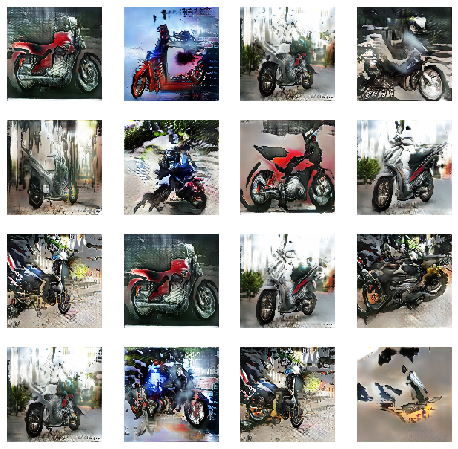

generator loss: 0.9415706992149353
discriminator loss: 1.3175346851348877
Time for epoch 661 is 702.258584022522 sec


In [0]:
START_ITER = 0
END_ITER = 200000
DISPLAY_FREQUENCY = 500
SAVE_FREQUENCY = 5000

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    latest_ckpt = tf.train.latest_checkpoint(CKPT_DIR)
    if latest_ckpt is None:
        print('No checkpoint found!')
    else:
        print('Found checkpoint : "{}"'.format(latest_ckpt))
        saver.restore(sess, latest_ckpt)
        START_ITER = int(latest_ckpt.split('-')[-1])

    for iteration in range(START_ITER, END_ITER):
        start = time.time()
        
        noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 1, 1, NOISE_DIM))
        _, disc_real_loss, disc_fake_loss = sess.run([disc_train_op, disc_real_loss_op, disc_fake_loss_op], 
                                                     feed_dict={generator.input: noise})
        _, gen_loss = sess.run([gen_train_op, gen_loss_op], feed_dict={generator.input: noise})
        
        # Produce images for the GIF as we go
        if iteration % DISPLAY_FREQUENCY == 0:
            display.clear_output(wait=True)
            generate_and_save_images(seed, sess, iteration)
            
            # print info
            dh1 = display.display('generator loss: {}'.format(gen_loss), display_id=True)
            dh2 = display.display('discriminator real loss: {}'.format(disc_real_loss), display_id=True)
            dh3 = display.display('discriminator fake loss: {}'.format(disc_fake_loss), display_id=True)
            dh4 = display.display('Time for iteration {}/{} is {} sec'.format(iteration + 1, 
                                                                              END_ITER, time.time()-start), display_id=True)
        
        dh1.update('generator loss: {}'.format(gen_loss))
        dh2.update('discriminator real loss: {}'.format(disc_real_loss))
        dh3.update('discriminator fake loss: {}'.format(disc_fake_loss))
        dh4.update('Time for iteration {}/{} is {} sec'.format(iteration + 1, END_ITER, time.time()-start))

        if (iteration + 1) % SAVE_FREQUENCY == 0:
            saver.save(sess, os.path.join(CKPT_DIR, 'model'), global_step=iteration + 1)